# First stab at GBR coral cover

## conceptual workflow 

In the longer run the aim is to sample geo-median imagery and other covariate data (depth, slope, etc) around in situ sample data dates, and then predict time-series coral cover  

For the moment, to get the hang of it, use a once-off longer time period mosaic and do categorical maps + coral cover. Something like:  
    
    1. Generate a once off nice composite, maybe a 2-3 year period (2017-2019? - gives access to Sentinel-2 Level 2?)  
    2. Maybe segmentation - **optional to begin with**  
    3. Sample from the whole trianing data set (*reef cloud*) [but for the moment sample the same time period and AOI as the mosaic]  
    4. Fit a ML model (e.g. RF or SVM etc.)  
    5. Explore and validate  

Step after that is OBIA (OBIA implementation for relationship/neighbourhood rules), moved to:  
`/coral_obia.ipynb`

**Cummulaive Q's:**
- once settled on a larger area, should I export the temporal composites (and segmentation etc.)?
- what are the costs for reprojection? Can you set to use the native/nominal projection of data?
- RE the `query` dictionary passed to the loading function or loading helper: does the `output_crs` only apply to output after the processing subsquent to the load, or does it always apply to every time-step found in the collection?  
- what happens when you stop execution while dask chunks are processing/queued (seems not to like that...)?  
- for lazy eval, is it quicker to `.load()`/`.compute()` just the individual bands, several at one, or the whole lot?  And if several at once, how to do that via the slot method (i.e. `lazy_dat.blue.load()` --> `lazy_day.some_bands.load()`  

    

## Front matter

In [10]:
%matplotlib inline
import os

import subprocess as sp
import sys
import datacube
import rasterio

import shapely

import pydotplus

import numpy as np
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt

from odc.ui import with_ui_cbk
from odc.algo import to_f32, xr_geomedian, int_geomedian

from io import StringIO

from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from joblib import dump, load

from IPython.display import Image
from datacube.utils import geometry
from datacube.utils.cog import write_cog

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_dask import create_local_dask_cluster
from dea_classificationtools import collect_training_data
from dea_classificationtools import predict_xr
from dea_plotting import map_shapefile

import warnings
warnings.filterwarnings('ignore') ## why?

dc = datacube.Datacube(app="coral_cover")

In [11]:
# just check where we are
print(os.getcwd())

/home/jovyan/clones/dea-notebooks/coral_reefs


## Load model input data

### In situ data

In [2]:
coral_dat = gpd.read_file("gbr_reefcloud_coral.shp")

# fix for the meantime to ensure projections line up
#coral_dat = coral_dat.to_crs('EPSG:3577')

In [3]:
print(type(coral_dat))
print(coral_dat.head())
print(coral_dat.shape[0])
print(coral_dat.crs)

# set the class field for sampling
class_field = "class_num"

'''
# select required cols?
coral_dat_lite = gpd.GeoDataFrame(coral_dat[[class_field]])
coral_dat_lite['geometry'] = coral_dat.geometry
print(coral_dat_lite.head())
'''

<class 'geopandas.geodataframe.GeoDataFrame'>
    Latitude   Longitude  Algae  BMA  Branching  HCOther  Massive  Inverts  \
0 -23.914512  152.396780    2.0  0.0        2.0      0.0      8.0      2.0   
1 -23.914497  152.396776    0.0  0.0        2.0      0.0     32.0      0.0   
2 -23.914478  152.396769    0.0  0.0        8.0      0.0      8.0      0.0   
3 -23.914444  152.396754    6.0  0.0        4.0      0.0     20.0      0.0   
4 -23.914412  152.396745    4.0  0.0        4.0      4.0     10.0      0.0   

   Plate  Rock  ...  Coral       DomBen  pa_branch  pa_massive pa_plate  \
0   20.0  20.0  ...   52.0  Coral/Algae          0           1        1   
1    0.0   2.0  ...   74.0  Coral/Algae          0           1        0   
2   12.0  14.0  ...   66.0  Coral/Algae          1           1        1   
3    4.0   2.0  ...   78.0  Coral/Algae          0           1        0   
4    0.0   0.0  ...   88.0  Coral/Algae          0           1        0   

   pa_soft  dominante_  class_num 

"\n# select required cols?\ncoral_dat_lite = gpd.GeoDataFrame(coral_dat[[class_field]])\ncoral_dat_lite['geometry'] = coral_dat.geometry\nprint(coral_dat_lite.head())\n"

In [13]:
# just subsample and plot to check
coral_dat['random'] = np.random.uniform(0, 1, coral_dat.shape[0])
coral_dat_sample = coral_dat[coral_dat.random > 0.999]
coral_dat_sample = coral_dat_sample.reset_index(drop=True)

#coral_dat_buffs = coral_dat_sample
#coral_dat_buffs['geometry'] = coral_dat_sample.geometry.buffer(0.0001)

print(coral_dat_sample.shape)
#print(coral_dat_buffs.shape)

(130, 24)


In [14]:
map_shapefile(coral_dat_sample, attribute = class_field)
#map_shapefile(coral_dat_buffs, attribute = class_field)

Label(value='')

Map(center=[-17.220572564999998, 147.71729829999998], controls=(ZoomControl(options=['position', 'zoom_in_text…

### Non-image covariate data

*still to come*
- Depth
- Wave climate

## Sample model cal/val data

### Image data
- Directly from imagery  
- In long term this will be wrapped into a function that will generate the sample `time:` period dynamically based on the in situ data collection date
- And when it get's big, there's be a flag to load the array of data and names

In [ ]:
# stop the dask cluster if it's running (try not to do any dask ops (e.g. geomedians) before this point)
# HOW? the client object doesn't seem to be exported?

#### Data already sampled?

In [27]:
run_image_sampling = False

In [42]:
if (run_image_sampling):
    
    samp_query = {
        "time": ("2019-06-01", "2019-06-30"),
        'group_by' :'solar_day',
        'measurements': ['nbar_coastal_aerosol', 'nbar_blue', 'nbar_green', 'nbar_red', 'nbar_nir_1'],
        'resolution': (-10,10),
        'output_crs': 'EPSG:3577'
    }

    column_names, model_input = collect_training_data(
                                        gdf=coral_dat_sample, # use the subset while developing
                                        products=["s2a_ard_granule", "s2b_ard_granule"],
                                        dc_query=samp_query,
                                        ncpus=2,
                                        custom_func=None,
                                        field=class_field,
                                        calc_indices=None,
                                        reduce_func='median',
                                        drop=False,
                                        zonal_stats='mean')

    # save the array (will eventually be big)
    np.save('modeldat_names.npy', column_names, allow_pickle=False)
    np.save('modeldat_input.npy', model_input, allow_pickle=False)
    
else:
    column_names = np.load('modeldat_names.npy').tolist()
    model_input = np.load('modeldat_input.npy')

In [55]:
print(column_names)
print(model_input[0:5,])
print(model_input.shape)
print(column_names.__class__)
print(model_input.__class__)

['class_num', 'nbar_coastal_aerosol', 'nbar_blue', 'nbar_green', 'nbar_red', 'nbar_nir_1']
[[  15. 1230.  822.  898.  301.   63.]
 [  15. 1168. 1424. 1611.  691.   93.]
 [  15. 1891. 1913. 2189. 1325.  623.]
 [  13.  828.  980. 1177.  508.  102.]
 [  11. 1623. 1882. 2404. 1595.  625.]]
(113, 6)
<class 'list'>
<class 'numpy.ndarray'>


### Stack in/sample non-image data
- depth
- waves

## Train model

**Fit the model or load a fitted model??**

In [45]:
do_fit = False
model_filename = 'fitted_model.joblib'

In [46]:
# split into cal/val
model_train, model_test = model_selection.train_test_split(model_input, 
                                                           stratify=model_input[:, 0],
                                                           train_size=0.8, 
                                                           random_state=0)
print("Train shape:", model_train.shape)
print("Test shape:", model_test.shape)

Train shape: (90, 6)
Test shape: (23, 6)


In [47]:
# Select the variables we want to use to train our model
model_variables = column_names[1:]

# Extract relevant indices from the processed shapefile
model_col_indices = [column_names.index(var_name) for var_name in model_variables]

In [48]:
if do_fit:    
    # Initialise random forest clasifier
    model = RandomForestClassifier(n_estimators=100,
                                   max_depth=20,
                                   min_samples_split=2,
                                   min_samples_leaf=2)

    # Train the model
    model.fit(model_train[:, model_col_indices], model_train[:, 0])
    # save model
    dump(model, model_filename)
else:
    model = load(model_filename)
    
print(model)

RandomForestClassifier(max_depth=20, min_samples_leaf=2)


### Model diagnostics

*... skipping variable importance, as i haven't had much luck with it being useful! ...*

Mainly interesting in accuracy since we have loads of data for validation

#### Accuracy

In [49]:
# predict into the test set and calcualte accuracy
test_preds = model.predict(model_test[:, model_col_indices])
accuracy_score(test_preds, model_test[:, 0])

0.4782608695652174

## Predict model into environmental space

### Load covariate data

#### Image composite (temporal)

In [50]:
# start the dask cluster
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:45197 Dashboard: /user/mitchest/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


In [51]:
# test extent for now - this will eventually be controlled by appliction or just a whole extent run

query = {
    "x": (151.48837, 152.22467),
    "y": (-23.17189, -23.60526),
    "time": ("2019-06-01", "2019-06-05"),
    "group_by": "solar_day",
    "resolution": (-10, 10),
    'measurements': ['nbar_coastal_aerosol', 'nbar_blue', 'nbar_green', 'nbar_red', 'nbar_nir_1'],
    'output_crs': 'EPSG:3577'
}

s2_collection = load_ard(dc=dc,
                         products=["s2a_ard_granule", "s2b_ard_granule"],
                         dask_chunks={"time": 1, "x": 2000, "y": 2000},
                         dtype='native',
                         **query)

print(s2_collection)

s2_geomedian = int_geomedian(s2_collection)
# compute - ideally i'd like to be able to load the bands at this point - possible? e.g. s2_geomedian.some_bands.load()
s2_geomedian = s2_geomedian.load()

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Applying pixel quality/cloud mask
Returning 2 time steps as a dask array
<xarray.Dataset>
Dimensions:               (time: 2, x: 8113, y: 5943)
Coordinates:
  * time                  (time) datetime64[ns] 2019-06-02T00:11:19.024000 20...
  * y                     (y) float64 -2.648e+06 -2.648e+06 ... -2.708e+06
  * x                     (x) float64 1.961e+06 1.961e+06 ... 2.042e+06
    spatial_ref           int32 3577
Data variables:
    nbar_coastal_aerosol  (time, y, x) int16 dask.array<chunksize=(1, 2000, 2000), meta=np.ndarray>
    nbar_blue             (time, y, x) int16 dask.array<chunksize=(1, 2000, 2000), meta=np.ndarray>
    nbar_green            (time, y, x) int16 dask.array<chunksize=(1, 2000, 2000), meta=np.ndarray>
    nbar_red              (time, y, x) int16 dask.array<chunksize=(1, 2000, 2000), meta=np.ndarray>
    nbar_nir_1            (time, y, x) int16 dask.array<chunksize=(1, 2000, 2000), meta=np.ndarray>
Attri

<xarray.Dataset>
Dimensions:               (x: 8113, y: 5943)
Coordinates:
  * y                     (y) float64 -2.648e+06 -2.648e+06 ... -2.708e+06
  * x                     (x) float64 1.961e+06 1.961e+06 ... 2.042e+06
Data variables:
    nbar_coastal_aerosol  (y, x) int16 -999 -999 -999 -999 ... 354 354 354 354
    nbar_blue             (y, x) int16 -999 -999 -999 -999 ... 252 235 228 212
    nbar_green            (y, x) int16 -999 -999 -999 -999 ... 140 131 152 145
    nbar_red              (y, x) int16 -999 -999 -999 -999 -999 ... 92 96 83 79
    nbar_nir_1            (y, x) int16 -999 -999 -999 -999 -999 ... 94 78 80 82
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


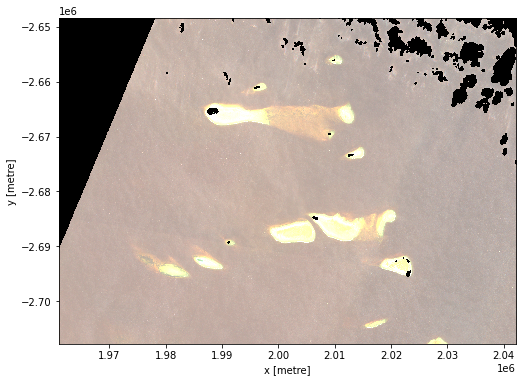

In [52]:
print(s2_geomedian)
rgb(s2_geomedian, bands = ['nbar_blue', 'nbar_green', 'nbar_red'])

#### Stack in non-image covariates

- depth
- waves

### Prediction into image

In [ ]:
#### Predict

In [54]:
# Predict the model into the imagery/covariates
stack_prediction = predict_xr(model, s2_geomedian)#, progress=True)

predicting...


In [3]:
print(stack_prediction)
print(stack_prediction.Predictions)

# should probably write in to go to int8 here at some point

NameError: name 'stack_prediction' is not defined

In [2]:
# Set up plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot classified image
stack_prediction.Predictions.plot.imshow(ax=axes[0],
                                  cmap='Set1', 
                                  add_labels=False, 
                                  add_colorbar=False)

# Plot true colour image
(s2_geomedian[['nbar_red', 'nbar_green', 'nbar_blue']]
 #.squeeze('time')
 .to_array()
 .plot.imshow(ax=axes[1], robust=True, add_labels=False))

# Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title('Map prediction')
axes[1].set_title('True colour image');

NameError: name 'plt' is not defined

#### Export

In [71]:
write_cog(stack_prediction.Predictions,
         'cap_bunk_benthic.tif',
          overwrite=True)

# should write this in a different format? .nc maybe?

PosixPath('cap_bunk_benthic.tif')